In [2]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

## Membaca Dataset Hasil Preprocessing

In [3]:
PATH = ""

In [4]:
data = pd.read_csv(PATH + 'detik_news_title_preprocessing.csv', delimiter=',')
data

,date,url,title,category,title_preprocessing
0,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,Kemnaker Awasi TKA di Meikarta,finance,kemnaker tka meikarta
1,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,BNI Digitalkan BNI Java Jazz 2020,finance,bni bni java jazz
2,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,"Terbang ke Australia, Edhy Prabowo Mau Genjot ...",finance,terbang edhy prabowo genjot budi daya lobster
3,02/26/2020,https://finance.detik.com/moneter/d-4916133/oj...,OJK Siapkan Stimulus Ekonomi Antisipasi Dampak...,finance,ojk siap stimulus ekonomi dampak corona
4,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,Saran Buat Anies-RK yang Mangkir Rapat Banjir ...,finance,saran mangkir rapat banjir dpr
...,...,...,...,...,...
70208,03/27/2020,https://sport.detik.com/detiktv/d-4954996/untu...,"Untuk Urusan Gaji, Ter Stegen Belum Bisa Samai...",sport,urus gaji ter stegen sama messi
70209,03/27/2020,https://sport.detik.com/detiktv/d-4954916/vide...,Video Stadion Sepakbola di Dunia Beralih Fungs...,sport,video stadion sepakbola dunia alih fungsi lawa...
70210,03/27/2020,https://sport.detik.com/raket/d-4954704/olimpi...,"Olimpiade 2020 Ditunda, Hendra Setiawan Berjua...",sport,olimpiade tunda hendra setiawan juang lawan usia
70211,03/27/2020,https://sport.detik.com/raket/d-4954759/wimble...,"Wimbledon 2020 Terancam Batal, Panitia Rapat D...",sport,wimbledon ancam batal panitia rapat darurat mi...


Menampilkan informasi data.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70213 entries, 0 to 70212
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date                 70213 non-null  object
 1   url                  70213 non-null  object
 2   title                70213 non-null  object
 3   category             70213 non-null  object
 4   title_preprocessing  70194 non-null  object
dtypes: object(5)
memory usage: 2.7+ MB


Menampilkan jumlah data Null setiap kolom.

In [6]:
data.isnull().sum()

date                    0
url                     0
title                   0
category                0
title_preprocessing    19
dtype: int64

Menghapus data jika dalam satu baris terdapat data Null.

In [7]:
data = data.dropna().reset_index(drop=True)

In [8]:
data.isnull().sum()

date                   0
url                    0
title                  0
category               0
title_preprocessing    0
dtype: int64

Menampilkan jumlah data masing-masing label.

In [9]:
data['category'].value_counts()

category
news       32352
hot        16325
finance    14165
health      4917
sport       2435
Name: count, dtype: int64

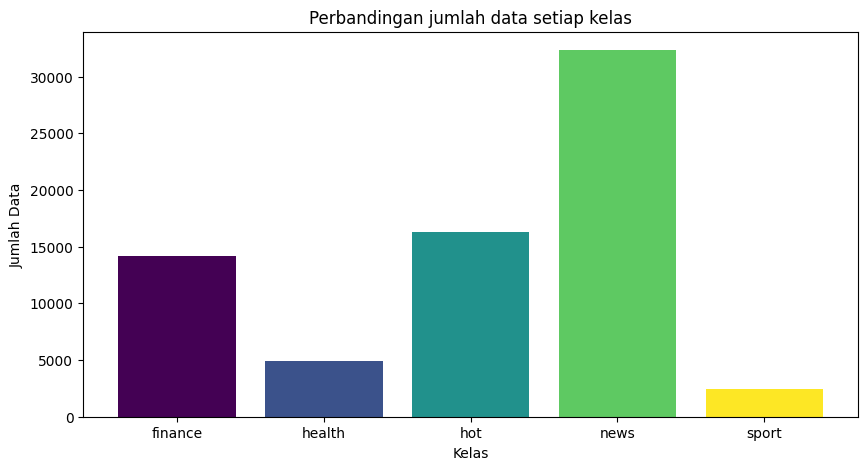

In [10]:
names = data.groupby(['category']).size().index.to_list()
values = data.groupby(['category']).size().to_list()

# Menghasilkan warna menggunakan colormap
num_colors = len(names)
colors = cm.viridis(np.linspace(0, 1, num_colors))

plt.figure(figsize=(10, 5))
plt.bar(names, values, color=colors)
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.title('Perbandingan jumlah data setiap kelas')
plt.show()

## Make smaller dataset

In [11]:
data_small = data.groupby(by="category").sample(2400)
data_small['category'].value_counts()

category
finance    2400
health     2400
hot        2400
news       2400
sport      2400
Name: count, dtype: int64

In [13]:
data_small['category'].value_counts()

category
finance    2400
health     2400
hot        2400
news       2400
sport      2400
Name: count, dtype: int64

## Word2Vec

In [20]:
X = data_small['title_preprocessing']  # Kolom teks
y = data_small['category']  # Kolom label

In [21]:
# Preprocess text for Word2Vec
def preprocess_text(text):
    return simple_preprocess(text)

# Apply preprocessing to the text column
X_df = pd.DataFrame({'title_preprocessing': data_small['title_preprocessing']})
X_df['processed_text'] = X_df['title_preprocessing'].apply(preprocess_text)
X_df

,title_preprocessing,processed_text
9063,harga emas turun,"[harga, emas, turun]"
5393,pemda endap uang bank semprit tito karnavian,"[pemda, endap, uang, bank, semprit, tito, karn..."
1973,saking susah cari kerja lulus rela awat lansia,"[saking, susah, cari, kerja, lulus, rela, awat..."
538,google klaim dolar jual beli,"[google, klaim, dolar, jual, beli]"
4399,iran trump irak,"[iran, trump, irak]"
...,...,...
68442,jadwal england,"[jadwal, england]"
68380,orang tottenham hotspur positif corona,"[orang, tottenham, hotspur, positif, corona]"
68429,rahmat hidayat juara junior ikut jejak hendra ...,"[rahmat, hidayat, juara, junior, ikut, jejak, ..."
68263,leo rolly bukti level senior,"[leo, rolly, bukti, level, senior]"


In [22]:
# Prepare Word2Vec model
# sg=1 : menggunakan skipgram
word2vec_model = Word2Vec(sentences=X_df['processed_text'], vector_size=150, window=5, sg=1)

In [23]:
def get_average_word2vec(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

X_df['word2vec'] = X_df['processed_text'].apply(lambda x: get_average_word2vec(x, word2vec_model))
X_df

,title_preprocessing,processed_text,word2vec
9063,harga emas turun,"[harga, emas, turun]","[-0.044055954, -0.11079609, 0.15794404, 0.1448..."
5393,pemda endap uang bank semprit tito karnavian,"[pemda, endap, uang, bank, semprit, tito, karn...","[-0.042243313, -0.09440703, 0.12887244, 0.1228..."
1973,saking susah cari kerja lulus rela awat lansia,"[saking, susah, cari, kerja, lulus, rela, awat...","[-0.058136903, -0.09416274, 0.12057579, 0.1197..."
538,google klaim dolar jual beli,"[google, klaim, dolar, jual, beli]","[-0.054525036, -0.085363485, 0.114021376, 0.12..."
4399,iran trump irak,"[iran, trump, irak]","[-0.06392362, -0.07763828, 0.10315969, 0.11796..."
...,...,...,...
68442,jadwal england,"[jadwal, england]","[-0.08528567, -0.07796863, 0.083887525, 0.1009..."
68380,orang tottenham hotspur positif corona,"[orang, tottenham, hotspur, positif, corona]","[-0.19609472, 0.014075954, 0.05328831, 0.08782..."
68429,rahmat hidayat juara junior ikut jejak hendra ...,"[rahmat, hidayat, juara, junior, ikut, jejak, ...","[-0.06428827, -0.07104124, 0.09907024, 0.11011..."
68263,leo rolly bukti level senior,"[leo, rolly, bukti, level, senior]","[-0.052680627, -0.06694909, 0.09116745, 0.0976..."


In [24]:
X_word2vec = np.array(X_df['word2vec'].tolist())
X_word2vec.shape

(12000, 150)

In [25]:
display("X_df.columns", X_df.columns)
display("Y", y)

'X_df.columns'

Index(['title_preprocessing', 'processed_text', 'word2vec'], dtype='object')

'Y'

9063     finance
5393     finance
1973     finance
538      finance
4399     finance
          ...   
68442      sport
68380      sport
68429      sport
68263      sport
69715      sport
Name: category, Length: 12000, dtype: object

## Membagi data menjadi training dan testing

In [26]:
# 80% training dan 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

print('Jumlah data train :', X_train.shape[0])
print('Jumlah data test  :', X_test.shape[0])

Jumlah data train : 9600
Jumlah data test  : 2400


## Naive Bayes

In [33]:
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB

### Bernoulli Naive-Bayes (BNB)

In [34]:
bnbclassifier = BernoulliNB()
bnbclassifier = bnbclassifier.fit(X_train, y_train)

In [36]:
y_pred = bnbclassifier.predict(X_test)
y_pred

array(['finance', 'hot', 'finance', ..., 'hot', 'news', 'health'],
      dtype='<U7')

In [37]:
Confusion_matrix = confusion_matrix(y_test, y_pred, labels=[1, 0, -1])
class_label      = ['Positif', 'Netral', 'Negatif', ]
df_confusion     = pd.DataFrame(Confusion_matrix, index = class_label, columns = class_label)

sns.heatmap(df_confusion, annot=True, fmt = "d", cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Prediction Label')
plt.ylabel('Actual Label')
plt.show()

TypeError: '<' not supported between instances of 'int' and 'str'

In [38]:
_accuracy   = round(accuracy_score(y_test, y_pred)*100, 2)
_precission = round(precision_score(y_test, y_pred, average='weighted')*100, 2)
_recall     = round(recall_score(y_test, y_pred, average='weighted')*100, 2)
_fscore     = round(f1_score(y_test, y_pred, average='weighted')*100, 2)

print('Accuracy   =', _accuracy,'%')
print('Precission =', _precission,'%')
print('Recall     =', _recall,'%')
print('F1-Score   =', _fscore,'%')

Accuracy   = 39.67 %
Precission = 40.2 %
Recall     = 39.67 %
F1-Score   = 36.01 %


### Gausian Naive-Bayes (GNB)

In [39]:
gnbclassifier = GaussianNB()
gnbclassifier = gnbclassifier.fit(X_train, y_train)

In [40]:
y_pred = gnbclassifier.predict(X_test)
y_pred

array(['finance', 'finance', 'finance', ..., 'hot', 'hot', 'health'],
      dtype='<U7')

In [41]:
Confusion_matrix = confusion_matrix(y_test, y_pred, labels=[1, 0, -1])
class_label      = ['Positif', 'Netral', 'Negatif', ]
df_confusion     = pd.DataFrame(Confusion_matrix, index = class_label, columns = class_label)

sns.heatmap(df_confusion, annot=True, fmt = "d", cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Prediction Label')
plt.ylabel('Actual Label')
plt.show()

TypeError: '<' not supported between instances of 'int' and 'str'

In [42]:
_accuracy   = round(accuracy_score(y_test, y_pred)*100, 2)
_precission = round(precision_score(y_test, y_pred, average='weighted')*100, 2)
_recall     = round(recall_score(y_test, y_pred, average='weighted')*100, 2)
_fscore     = round(f1_score(y_test, y_pred, average='weighted')*100, 2)

print('Accuracy   =', _accuracy,'%')
print('Precission =', _precission,'%')
print('Recall     =', _recall,'%')
print('F1-Score   =', _fscore,'%')

Accuracy   = 38.46 %
Precission = 44.65 %
Recall     = 38.46 %
F1-Score   = 35.17 %


## Support Vector Machine (SVM)

In [43]:
svclassifier = SVC(kernel='linear', C=100, gamma=10)
svclassifier.fit(X_train, y_train)

SVC(C=100, gamma=10, kernel='linear')

In [44]:
y_pred = svclassifier.predict(X_test)
y_pred

array(['finance', 'hot', 'finance', ..., 'finance', 'health', 'health'],
      dtype=object)

In [ ]:
Confusion_matrix = confusion_matrix(y_test, y_pred, labels=["news, sport, hot, finance, health"])
class_label      = ['Positif', 'Netral', 'Negatif', ]
df_confusion     = pd.DataFrame(Confusion_matrix, index = class_label, columns = class_label)

sns.heatmap(df_confusion, annot=True, fmt = "d", cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Prediction Label')
plt.ylabel('Actual Label')
plt.show()

ValueError: At least one label specified must be in y_true

In [46]:
_accuracy   = round(accuracy_score(y_test, y_pred)*100, 2)
_precission = round(precision_score(y_test, y_pred, average='weighted')*100, 2)
_recall     = round(recall_score(y_test, y_pred, average='weighted')*100, 2)
_fscore     = round(f1_score(y_test, y_pred, average='weighted')*100, 2)

print('Accuracy   =', _accuracy,'%')
print('Precission =', _precission,'%')
print('Recall     =', _recall,'%')
print('F1-Score   =', _fscore,'%')

Accuracy   = 69.75 %
Precission = 70.39 %
Recall     = 69.75 %
F1-Score   = 69.86 %
